# Notebook do jednowymiarowej symulacji FDTD

Importowanie bibliotek

In [1]:
#%matplotlib inline
#import matplotlib.pyplot as plt

#from matplotlib import animation, rc
#from IPython.display import HTML

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
from numba import jit

#import time

Ustalamy stałe: $\epsilon_0$ i $\mu_0$. W celu weryfikacji obliczamy prędkość światła $c$.

In [2]:
epsilon0 = 625000/(22468879468420441*np.pi) 
mu0 = np.pi/2500000
c = 1/np.sqrt(epsilon0*mu0)
c

299792458.0

Definiiujemy parametry siatki: 
- długość przewodu $l$
- krok siatki $dx$
- krok czasowy $dt$

Na ich podstawie ustawiamy wielkość siatki: $nx$


In [3]:
l = 1000 # m
dx = 1  #m
dt = 10e-10 # s
nx = int(l/dx)
nx

1000

Sprawdzamy warunek zbieżności

In [4]:
dx/dt > c

True

Alokacja siatki na $E_z$ oraz $H_y$, a także wartości $\sigma$

In [14]:
ez = np.zeros(nx)
hy = np.zeros(nx)

sigma = 0.00001 * np.ones(nx)
for i in range(100):
    sigma[i] *= np.exp((100-i)/10)
    sigma[nx-i-1] *= np.exp((100-i)/10)
    
sigma
#sigma = 10**(-3) * load_data(nx)
#source = load_source()
#j = load_current()

array([2.20264658e-01, 1.99303704e-01, 1.80337449e-01, 1.63176072e-01,
       1.47647816e-01, 1.33597268e-01, 1.20883807e-01, 1.09380192e-01,
       9.89712906e-02, 8.95529270e-02, 8.10308393e-02, 7.33197354e-02,
       6.63424401e-02, 6.00291222e-02, 5.43165959e-02, 4.91476884e-02,
       4.44706675e-02, 4.02387239e-02, 3.64095031e-02, 3.29446808e-02,
       2.98095799e-02, 2.69728233e-02, 2.44060198e-02, 2.20834799e-02,
       1.99819590e-02, 1.80804241e-02, 1.63598443e-02, 1.48029993e-02,
       1.33943076e-02, 1.21196707e-02, 1.09663316e-02, 9.92274716e-03,
       8.97847292e-03, 8.12405825e-03, 7.35095189e-03, 6.65141633e-03,
       6.01845038e-03, 5.44571910e-03, 4.92749041e-03, 4.45857770e-03,
       4.03428793e-03, 3.65037468e-03, 3.30299560e-03, 2.98867401e-03,
       2.70426407e-03, 2.44691932e-03, 2.21406416e-03, 2.00336810e-03,
       1.81272242e-03, 1.64021907e-03, 1.48413159e-03, 1.34289780e-03,
       1.21510418e-03, 1.09947172e-03, 9.94843156e-04, 9.00171313e-04,
      

Usjalamy źródło w postaci Gaussianu

In [15]:
#s = 20*dt
#m = 50*dt
#l = 200 
#gauss = [ 10e-11* 1/(s * np.sqrt(2 * np.pi)) * np.exp( - (t*dt - m)**2 / (2 * s**2) ) for t in range(l) ]
p = int(nx/2)
#source = [ (p, gauss[t]) for t in range(l)  ]
#source

def source(time):
    p = int(nx/2)
    return p, np.sin(2 * np.pi * (0 - 0.005 * time))

Zmienne pomocnicze usprawniające obliczenia (stałe w czasie współczynniki obliczamy raz, a nie za każdym razem)

In [16]:
coef_e_loss = [ (epsilon0 - sigma[i]*dt/2)/(epsilon0 + sigma[i]*dt/2) for i in range(nx) ]
coef_e_step = [ dt/(dx*(epsilon0 + sigma[i]*dt/2)) for i in range(nx) ]
coef_h_step = [ dt/(dx*mu0) for i in range(nx) ]
coef_j = [ dt/(epsilon0 + sigma[i]*dt/2) for i in range(nx) ]

In [17]:
coef_e_loss[3]

-0.8042023416751322

In [18]:
coef_e_step[3]

11.056782528105977

In [19]:
coef_h_step[3]

0.0007957747154594768

Funkcje pomocnicze wykonujące kroki symulacji. Warunki brzegowe ustalamy jako zerowe pole.

In [20]:
#@jit(nopython=True)
def e_interior_update():
    for i in range(1,nx-1):
        ez[i] = coef_e_loss[i]*ez[i] + coef_e_step[i]*(hy[i]-hy[i-1])
        
#@jit(nopython=True)
def h_interior_update():
    for i in range(1,nx-1):
        hy[i] = hy[i] + coef_h_step[i]*(ez[i+1]-ez[i])
        
#@jit(nopython=True)
#def e_current_apply(ez, coeff, j):
#    for jt in j:
#        ez[jt[0]] = ez[jt[0]] - coeff[jt[0]] * jt[1]
        
def e_boundary_conditions():
    #ez[0] = ez[-1]
    pass
    
def h_boundary_conditions():
    #hy[0] = hy[-1]
    pass

def e_source(time):
    point, val = source(t)
    if point is not None:
        ez[point] = val
        ez[point-1] = 0.8*val
        ez[point+1] = 0.8*val
            

In [21]:
#for t in range(100):
#    e_interior_update()
 #   e_boundary_conditions()
 #   e_source(time = t)
#    
 #   h_interior_update()
 #   e_boundary_conditions()
 #   print( ez[p])

<IPython.core.display.Javascript object>


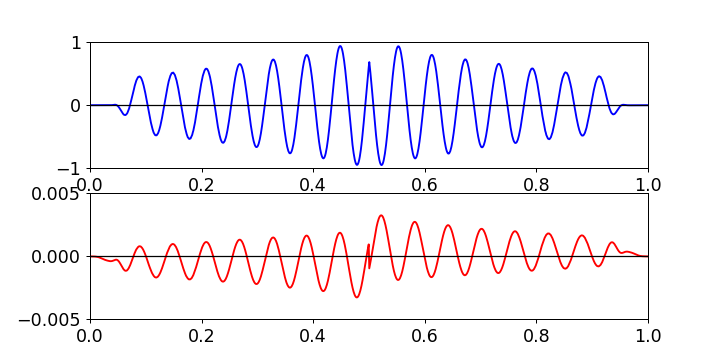

In [28]:
#??????
x = np.linspace(0, 1, nx)

# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 4))

# creating our line objects for the plots
ezplot, = ax1.plot(x, ez, '-b')
hyplot, = ax2.plot(x, hy, '-r')

def animate(t):
    """
    funkcja wywoływana przez animacje w celu obliczenia kolejnego kroku symulacji
    
    t: czas
    
    return:
        ezplot: ydata
        hyplot: ydata
    """
    
    for i in range(1):
        e_interior_update()
        #e_boundary_conditions()
        ez[p]= source(t)[1]

        h_interior_update()
        #h_boundary_conditions()
    
    ezplot.set_ydata(ez)
    hyplot.set_ydata(hy)


def init():
    """
    initialize the figure
    """
    
    ax1.set_ylim(-1, 1)
    ax2.set_ylim(-0.005, 0.005)

    ax1.set_xlim(0, 1)
    ax2.set_xlim(0, 1)
    ax1.axhline(0, color='black', lw=1)
    ax2.axhline(0, color='black', lw=1)
    plt.rcParams.update({'font.size':14})
    
    return ezplot, hyplot,

# the FuncAnimation function iterates through our animate function using the steps array
#step = 1
#steps = np.arange(0, 100, step)
ani = FuncAnimation(fig, animate, init_func=init, interval=50, blit=True)
plt.show()

Funkcje pomocnicze

In [25]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())

NameError: name 'animation' is not defined

Zmienne pomocnicze do pętli